<a href="https://colab.research.google.com/github/redinbluesky/nlp-with-transformers/blob/main/06_요약.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import nbformat
nb = nbformat.read("/content/drive/MyDrive/11.GIT_HUB/nlp-with-transformers/06-요약.ipynb", as_version=nbformat.NO_CONVERT)
if "widgets" in nb.metadata and "state" not in nb.metadata.widgets:
  nb.metadata["widgets"] = {"state": {}}
nbformat.write(nb, "notebook_fixed.ipynb")

#  목차
* [Chapter 0 개요](#chapter0)
* [Chapter 1 CNN/DailyMail 데이터셋](#chapter1)
* [Chapter 2 텍스트 요약 파이프라인](#chapter2)
    * [Chapter 2-1 요약 기준 모델](#chapter2-1)
    * [Chapter 2-2 GPT-2](#chapter2-2)    
    * [Chapter 2-3 T5](#chapter2-3)    
    * [Chapter 2-4 BART](#chapter2-4)    
    * [Chapter 2-5 PEGASUS](#chapter2-5)    
* [Chapter 3 요약결과 비교](#chapter3)    
* [Chapter 4 생성된 텍스트 품질 평가하기](#chapter4)
    * [Chapter 4-1 BLEU](#chapter4-1)
    * [Chapter 4-2 ROGUE](#chapter4-2)
* [Chapter 5 CNN/DailyMail 데이터셋에서 PEGASUS 평가하기](#chapter5)    
* [Chapter 6 요약모델 훈련하기](#chapter6)    
    * [Chapter 6-1 SAMSum에서 PEGASUS 평가하기](#chapter6-1)    
    * [Chapter 6-2 PEGASUS 미세튜닝하기](#chapter6-2)    
    * [Chapter 6-3 대화요약 생성하기](#chapter6-3)    

## Chapter 0 개요 <a class="anchor" id="chapter0"></a>
1. 문서의 요약은 긴 단락을 이해하고, 관련 내용을 추론하고, 원본 텍스트의 주제를 통합해 유창한 텍스트를 생성하는 능력이 필요한다.

2. 기사와 법률 계약서의 요약하는 방법은 매우 다르기 때문에 도메인에 맞는 일반화가 필요하다.

3. 사전 훈련된 트랜스포머를 사용해 몬수럴 요약하는 방법을 살펴본다.

4. 인코더-디코더 모델을 만들어 여러 사람이 주고받은 언어를 간결하게 요약해본다.

## Chapter 1 CNN/DailyMail 데이터셋 <a class="anchor" id="chapter1"></a>
1. CNN/DailyMail 데이터셋은 뉴스 기사와 해당 기사의 요약문으로 구성된 대규모 데이터셋이다.
    - 요약문은 기사에 첨부한 글머리 목록의 내용이다.
    - 요약이 본문에서 추출되지 않고 추상적이라는 중요한 특징이 있다.
    - 단순한 발췌가 아니라 새로운 문장으로 구성됐다.

2. 데이터셋은 세 가지 특성이 있다.
    - article: 뉴스 기사 본문
    - highlights: 뉴스 기사의 요약문
    - id: 각 샘플의 고유 식별자

In [1]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
print(f"특성1: {dataset['train'].column_names}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

특성1: ['article', 'highlights', 'id']


In [2]:
sample = dataset["train"][1]
print(f"""기사 문자 발췌, 총 길이: {len(sample['article'])}""")
print(sample["article"][:500], "...")
print(f"\n요약 (길이: {len(sample['highlights'])}):")
print(sample["highlights"])

기사 문자 발췌, 총 길이: 4051
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s ...

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


3. 기사가 요약에 비해 매우 긴 경우도 있다.
    - 트랜스포모 모델의 문맥 크기가 제한적이기 때문에 긴 기사를 처리하는 데 어려움이 있다.
    - 일반적으로 긴 기사에서 중요한 정보를 추출하는 전처리 단계가 필요하다.
    - 가장 간단한 방법은 모델의 문맥의 크기에 맞게 기사를 자르는 것이다.
    - 텍스트의 끝 부분에 중요한 정보가 있다면 사라지겠지만, 이는 모델 구조의 제약으로 생기는 불가피한 손실이다.

## Chapter 2 텍스트 요약 파이프라인 <a class="anchor" id="chapter2"></a>
1. 요약 작업에 많이 사용되는 트랜스포머 모델을 몇가지 살펴본다.
    - 모델의 초대 입력 크기는 각각 다르지만 동일한 입력을 사용하기 위해 입력 텍스트를 2,000자로 제한한다.

In [3]:
sample_text = dataset["train"][1]["article"][:2000]
print(f"입력 문자 발췌, 총 길이: {len(sample_text)}")
print(sample_text, "...")
# 딕셔너리의 요약을 저장한다.
summaries = {}

입력 문자 발췌, 총 길이: 2000
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less

2. 요약에서는 관례적으로 요약 문장을 줄바꿈으로 나눈다.
    - 마침표마다 그 뒤에 줄바꿈 토큰을 추가해도 되지만, 이런 경우 "U.S."와 같은 약어가 있는 문장에서 줄바꿈이 잘못 삽입될 수 있다.
    - NLTK(Natural Language Toolkit)와 같은 라이브러리를 사용해 문장 경계를 감지하는 것이 더 정확하다.

In [4]:
#%pip install nltk
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
nltk.download('punkt_tab')


string = "The U.S are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['The U.S are a country.', 'The U.N. is an organization.']

### Chapter 2-1 요약 기준 모델 <a class="anchor" id="chapter2-1"></a>
1. 기사를 요약하는 일반적인 기준 모델은 단순히 기사에 맨 처음 문장 세 개를 선택하는 것입니다.
    - 이는 기사의 중요한 정보가 처음에 배치되는 경향이 있기 때문입니다.
    - 이 기준 모델은 복잡한 모델과 비교할 때 성능을 평가하는 데 유용합니다.
    - NLTK 문장 토크나이져로 문장을 분리한 후 처음 세 문장을 선택합니다.

In [5]:
import nltk
from nltk.tokenize import sent_tokenize

def three_sentence_summary(text):
    sentences = sent_tokenize(text)
    return "\n".join(sentences[:3])

summaries["baseline"] = three_sentence_summary(sample_text)
print("기준 모델 요약:")
print(summaries["baseline"])

기준 모델 요약:
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."


### Chapter 2-2 GPT-2 <a class="anchor" id="chapter2-2"></a>
1. GPT-2는 주어진 프롬프트로 텍스트를 생성할 수 있다.
    - 입력 텍스트 위에 "TL;DR"이라는 토큰을 추가해 요약을 생성하도록 유도할 수 있다.


In [7]:
# 트랜스포머늬 pipline 함수로 요약 작업을 수행한다.
from transformers import pipeline, set_seed
from nltk.tokenize import sent_tokenize

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = f"{sample_text}\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query):]))


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


### Chapter 2-3 T5 <a class="anchor" id="chapter2-3"></a>
1. T5 모델은 "summarize:"라는 프롬프트를 사용해 요약 작업을 수행할 수 있다.
    - T5는 다양한 자연어 처리 작업을 하나의 통합된 프레임워크로 다룰 수 있는 강력한 모델이다.
    - 요약 작업에 특화된 프롬프트를 사용해 모델이 요약을 생성하도록 유도할 수 있다.
    - 요약을 포함해 여러 작업에서 비지도 학습 데이터와 지도 학습 데이터를 섞은 데이터로 훈련되었다.
    - 미세 튜닝 없이 체크포인트를 사전 훈련에 썼던 것과 동일한 프롬프트를 사용해 요약 작업을 수행할 수 있다.

2. 요약과정을 그림으로 표혀나면 아래와 같다.

     ![T5](image/05_02_t5.png)

In [8]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


### Chapter 2-4 BART <a class="anchor" id="chapter2-4"></a>
1. 손상된 입력을 재구성하도록 훈련되었다.
    - BART는 인코더-디코더 아키텍처를 사용해 텍스트를 요약하는 데 효과적이다.
    - 입력 텍스트의 일부를 마스킹하거나 삭제한 후, 모델이 원본 텍스트를 재구성하도록 훈련된다.
    - 이 과정에서 모델은 중요한 정보를 추출하고 요약하는 능력을 학습한다.
    - BERT와 GPT-2의 사전 훈련 방식을 결합한다.
    - CNN/DailyMail 데이터셋에 미세 튜닝된 "facebook/bart-large-cnn" 체크포인트를 사용해 요약 작업을 수행한다.

In [9]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


### Chapter 2-5 PEGASUS <a class="anchor" id="chapter2-5ㄷ"></a>
1. 인코더-디코더 아키텍처를 사용해 텍스트 요약에 특화된 모델이다.
    - PEGASUS는 문서에서 중요한 문장을 마스킹한 후, 모델이 이를 예측하도록 훈련된다.
    - 이 방식은 요약 작업에 매우 효과적이며, 모델이 핵심 정보를 추출하는 능력을 향상시킨다.
    - CNN/DailyMail 데이터셋에 미세 튜닝된 "google/pegasus-cnn_dailymail" 체크포인트를 사용해 요약 작업을 수행한다.

2. 일반적인 언어 모델링보다 요약에 특화된 산전 훈련 목표를 찾기 위해 대규모 말뭉치에서 주변 문단의 내용을 대부분 담은 문장을 자동으로 식별했다.
    - 이러한 문장은 문서 요약에 중요한 역할을 한다.
    - PEGASUS는 이러한 문장을 마스킹하고, 모델이 이를 예측하도록 훈련된다.
    - 이 과정에서 모델은 요약에 필요한 핵심 정보를 추출하는 능력을 학습한다.
    - 그림으로 표현하면 아래와 같다.

        ![PEGASUS](image/05_03_pegasus.png)

In [10]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
# 줄바끔하는 특수 토큰이 있으므로 sent_tokenize 사용이 필요없다.
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(".</n>", ".\n").strip()

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cuda:0


## Chapter 3 요약결과 비교 <a class="anchor" id="chapter3"></a>
1. GPT-2 모델은 데디터 셋에서 전혀 훈련되지 않았다.
2. BART와 PEGASUS 모델은 CNN/DailyMail 데이터셋에 미세 튜닝되었다.

In [11]:
print("요약 결과 비교:\n")
print(dataset["train"][1]["highlights"])

for model_name in summaries:
    print(f"\n{model_name.upper()}")
    print(summaries[model_name])
    print("")


요약 결과 비교:

Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."


GPT2
The mentally ill aren't being treated properly and are being housed in an environment that is not comfortable or conducive to their treatment.
A lot of the mentally ill are in jail because they are not in treatment.
The

3. 네 가지 모델 모두 정상적으로 합리적인 결과를 냈다.

4. 지표를 하나 정의하고 특정 벤치마크 데이터셋에서 모든 모델을 평가해 성능이 최고인 모델을 선택하는 것이 이상적인 방법니다.

## Chapter 4 생성된 텍스트 품질 평가하기 <a class="anchor" id="chapter4"></a>
1. 평가 지표가 나쁘면 모델의 성능 저하를 눈치 채지 못하고, 평가 지표가 비즈니스 목표에 맞지 않으면 어떤 가치도 창줄할 수 없다.

2. 생성된 텍스트를 평가하는 데 가정 널리 사용되는 두 지표는 BLEU와 ROGUE이다.

### Chapter 4-1 BLEU <a class="anchor" id="chapter4-1"></a>
1. 생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 똑같이 정렬됐는지 확인하는 대신, 단어 또는 n-그램을 체크한다.

2. 정밀도를 근간으로 하는지표이다.
    - 두텍스트를 비교할 때 참조 텍스트에 있는 단어가 생선된 텍스트에 얼마나 자주 등장하는지 카운트한다. 그 후에 생성된 텍스트 길이로 나눈다.
    - 단어를 참조 텍스트에 등장한 횟수만큼만 카운트한다.

3. 예를 들어 참조 텍스트가 "the cat is on the mat"이고 생성된 텍스트가 "the the the the the the"라고 가정하면 정밀도는 아래와 같이 계산된다.
    - pvanilla = 6 / 6 = 1
    - pmod = 2 / 6 = 0.33

4. n-그램에서 정밀도를 계산할 수도 있다.
    - P_n = ∑_C(n-gram)∈Generated Text min(Count in Generated Text, Count in Reference Text)  / ∑_C(n-gram)∈Generated Text Count in Generated Text
        - 여기서 C(n-gram)은 생성된 텍스트에 있는 모든 n-그램의 집합이다.
        - Count in Generated Text는 생성된 텍스트에서 n-그램 C의 등장 횟수이다.
    - 반복적인 생성에 보상을 주지 않도록 분자의 카둔트는 크리핑 한다.

5. 재현률를 고려하지 않기 때문에 짧지만 정밀하게 생성된 시퀸스가 긴 문장보다 유리하다.
    - 이를 해결하기 위해 생성된 텍스트 길이가 참조 텍스트 길이보다 짧을 때 패널티를 부여하는 브레브티 페널티(brevity penalty)를 도입한다.
    - BP = 1, if c > r
    - BP = exp(1 - r/c), if c ≤ r
        - 여기서 c는 생성된 텍스트의 길이, r은 참조 텍스트의 길이이다.

6. 최종 BLEU 점수는 브레브티 페널티와 n-그램 정밀도의 기하평균을 곱한 값이다.
    - BLEU = BP * exp(∑_n=1^N w_n log P_n)
        - 여기서 w_n은 n-그램 정밀도의 가중치이다. 일반적으로 모든 n에 대해 동일한 가중치를 사용한다.

7. 토큰화된 텍스트를 기대한다.
    - 일반적으로 소문자 변환, 구두점 제거, 토큰화 등의 전처리 단계를 거친다.
    - 텍스트 토큰화를 정확히 같은 방식으로 수행하지 않으면 BLEU 점수가 크게 달라질 수 있다.
    - ScareBLUE는 토큰화 단계를 내재화해 이러한 문제를 해결한다.

In [13]:
%pip install evaluate sacrebleu
import evaluate

bleu_metric = evaluate.load("sacrebleu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 9.4 MB/s eta 0:00:00


8. belu_metric 개체는 MEtric 클래스의 인스턴스로 하나의 수집기 처럼 작동한다.
    - add() 메서드에 샘플 하나를 추가하거나, add_batch() 메서드에 샘플 묶음을 추가할 수 있다.
    - compute() 메서드를 호출해 최종 BLEU 점수를 계산한다.

In [14]:
import pandas as pd
import numpy as np

bleu_metric.add(predictions="the the the the the the",references=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p,2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [15]:
bleu_metric.add(predictions="the cat is on mat",references=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p,2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### Chapter 4-2 ROUGE <a class="anchor" id="chapter4-2"></a>
1. 높은 재현율이 정밀도보다 훨씬 중요한 요약 같은 애플리케이션을 위해 특별히 개발되었다.
    - ROUGE는 생성된 텍스트와 참조 텍스트 간의 중복된 n-그램, 단어 시퀀스 및 단락을 측정하는 데 사용되는 평가 지표 모음이다.
    - ROUGE-N, ROUGE-L, ROUGE-S 등 여러 변형이 있다.
    - ROUGE-N은 n-그램 재현율을 측정한다.
    - ROUGE-L은 가장 긴 공통 부분 수열(Longest Common Subsequence, LCS)을 기반으로 한다.
    - ROUGE-S는 단어 쌍의 재현율을 측정한다.

2. 클리핑 카운트를 하디 않은 BLEU 공식으로 정밀도를 측정한 다음 정밀도돠 재현율 ROUGE 점수를 평군하면 F1 점수를 얻을 수 있다.

In [17]:
%pip install rouge_score
rouge_metric = evaluate.load("rouge")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=779eb1160b39f4b3570070bce3f5206cf411952abd5fbbbaac4c757fc7c765da
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [18]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    prediction = summaries[model_name]
    rouge_metric.add(prediction=prediction, reference=reference)
    score = rouge_metric.compute()
    rounge_dic = dict((rn, score[rn]) for rn in rouge_names)
    records.append(rounge_dic)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.136364,0.018349,0.100000,0.118182
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.488889,0.318182,0.422222,0.444444


## Chapter 5 CNN/DailyMail 데이터셋에서 PEGASUS 평가하기 <a class="anchor" id="chapter5"></a>
1. 처음 세 문장을 사용하든 기준 모델의 성능을 평가한다.

In [19]:
def evaluate_summaries_baseline(dataset, metric, column_text="article", column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

2. 데이터 일부에 함수를 적용한다.
    - CNN/DailyMail 데이터셋의 처음 1,000개 샘플에 기준 모델을 적용해 요약을 생성한다.

In [20]:
import pandas as pd
import numpy as np

test_sampled = dataset["test"].shuffle(seed=42).select(range(10))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
pd.DataFrame.from_dict(score, orient="index", columns=["Value"])

,Value
rouge1,0.354173
rouge2,0.139961
rougeL,0.224863
rougeLsum,0.322309


In [21]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [22]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


In [ ]:
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.365079,0.145161,0.206349,0.285714


## Chapter 6 요약모델 훈련하기  <a class="anchor" id="chapter6"></a>
1. 삼성이 만든 SAMSum 데이터셋을 사용해 요약 모델을 훈련한다.
    - 대화와 짧은 요약으로 구성되어있다.
    - 고객과 고객지원센타 간의 상호작용을 나타낸다.
    

In [23]:
from datasets import load_dataset

dataset_samsum = load_dataset("knkarthick/samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14731 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

분할 크기: [14731, 818, 819]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


2. 이 대화는 SMS나 왓츠앱에서 주고받은 내용이다.
    - 이모지와 GIF를 위한 플레이스 홀더가 포함되어있다.
    - dialogue 필드는 전체 텍스트를 포함하고, summary 필드는 요약문을 포함한다.

### Chapter 6-1 SAMSum에서 PEGASUS 평가하기  <a class="anchor" id="chapter6-1"></a>
1. PEGASUS 모델을 사용해 SAMSum 데이터셋에서 요약 작업을 수행한다.
    - "google/pegasus-cnn_dailymail" 체크포인트를 사용해 미세 튜닝된 PEGASUS 모델을 불러온다.
    - 토크나이저도 함께 불러온다.
    - 테스트 세트에서 무작위로 10개의 샘플을 선택해 평가한다.
    - evaluate_summaries_pegasus() 함수를 사용해 요약을 생성하고, ROUGE 지표로 성능을 평가한다.

In [24]:
from transformers import pipeline, set_seed
set_seed(42)

pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("\n생성된 요약:")
print(pipe_out[0]["summary_text"].replace("<n>", "\n"))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)



생성된 요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together .
Hannah: I'd rather you texted him .
Amanda: Just text him .


2. CNN/DailyMail 데이터셋에서는 비교적 잘 맞았지만 SAMSum 데이터셋에서는 성능이 떨어진다.
    - 이는 SAMSum 데이터셋의 대화체 언어와 짧은 요약이 CNN/DailyMail 데이터셋의 뉴스 기사와 요약과는 상당히 다르기 때문이다.
    - 도메인 차이로 인해 모델이 새로운 데이터셋에 일반화하는 데 어려움을 겪을 수 있다.
    - SAMSum 데이터셋에 맞게 모델을 미세 튜닝하거나, 대화체 언어에 특화된 모델을 사용하는 것이 필요하다.

In [25]:
import evaluate

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

rouge_metric = evaluate.load("rouge")

score = evaluate_summaries_pegasus(dataset_samsum["test"].shuffle(seed=42).select(range(10)), rouge_metric,
                                   model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


In [ ]:
import pandas as pd

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.272742,0.05355,0.200199,0.201927


3. 룬련 전에 평가 파이프라인을 준비해두면 두 가지 이점이 있다.
    - 첫째, 훈련 중간에 모델 성능을 정기적으로 평가해 과적합 여부를 모니터링할 수 있다.
    - 둘째, 훈련이 끝난 후 모델의 최종 성능을 신속하게 평가할 수 있다.

### Chapter 6-2 미세튜닝하기  <a class="anchor" id="chapter6-2"></a>
1. 대부분의 대화는 100 ~ 200개 토큰으로 구성되면 CNN/DailyMail 데이터셋의 기사보다 훨씬 짧다.
    - 요약도 마찬가지로 짧다.

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


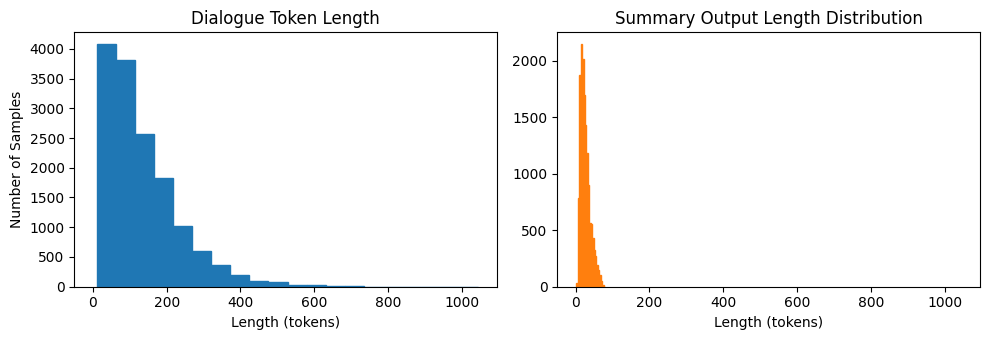

In [26]:
# 입력과 출력 길이의 분포를 살펴본다.
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharex=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length (tokens)")
axes[0].set_ylabel("Number of Samples")
axes[1].hist(s_len, bins=20, color="C1", edgecolor="C1")
axes[1].set_title("Summary Output Length Distribution")
axes[1].set_xlabel("Length (tokens)")
plt.tight_layout()
plt.show()

In [27]:
# 콜레이터 생성
def convert_examples_to_features(example_batch):
    input_enncodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True,)

    # 디코더 입력에 특수 토크나이저를 사용한다.
    #   - 디코더를 위한 토큰화임을 인지하고 그에 따라 시퀸스를 처리한다.
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True,)

    return {"input_ids": input_enncodings["input_ids"],
            "attention_mask": input_enncodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

2. 데이터 콜러레이터를 생성한다.
    - 배치를 모델에 주입하기 전에 Trainer에 의해 호출된다.
    - 인코더-디코더 모델에 맞는 seq2seq 데이터 콜러레이터를 사용한다.
    - 디코더에 티처 포싱을 적용한다.
        - 티처 포싱(teacher forcing)은 시퀀스 생성 모델을 훈련할 때 사용되는 기법으로, 모델이 이전에 생성한 토큰 대신 실제 정답 토큰을 입력으로 받도록 하는 방법이다.
        - 한 토큰 이동된 실제 요약을 디코더 입력으로 사용해 훈련 속도를 높이고, 더 안정적인 그래디언트 신호를 제공한다.

            ![티처 포싱](image/06_01_teacher_forcing.png)

3. 한 스텝 이송했으므로 디코더는 이전 스텝의 정답 레이블만 보며 현재와 미래의 레이블을 보지 못한다.
    - 디코더는 현재와 미래의 모든 입력을 마스킹하는 마스크드 셀프 어텐션을 갖기 때문에 문제없다.

In [28]:
# 한 스텝 오른쪽으로 이동시켜 디코더 입력을 만든다.
#   - DataCollatorForSeq2Seq는 이를 자동으로 처리한다.
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [29]:
# TrainerArguments 설정
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./pegasus-samsum",
    num_train_epochs=1,
    warmup_steps=100,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=True,
    eval_strategy="steps",
    save_steps=100,
    eval_steps=100,
    gradient_accumulation_steps=2) # 배치 크기가 작으므로 그래디언트 누적을 사용한다.

In [30]:
# 허깅스페이스에 로그인한다.
from huggingface_hub import notebook_login
notebook_login()

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_samsum_pt["train"].shuffle(seed=42).select(range(10)),
    eval_dataset=dataset_samsum_pt["validation"].shuffle(seed=42).select(range(10)),
    data_collator=seq2seq_data_collator,
    tokenizer=tokenizer,
)

/tmp/ipython-input-1005775634.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [33]:
trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: ERROR Invalid API key: API key must have 40+ characters, has 37.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: ERROR Invalid API key: API key must have 40+ characters, has 1.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=5, training_loss=3.235430145263672, metrics={'train_runtime': 118.462, 'train_samples_per_second': 0.084, 'train_steps_per_second': 0.042, 'total_flos': 3987122282496.0, 'train_loss': 3.235430145263672, 'epoch': 1.0})

In [34]:
score = evaluate_summaries_pegasus(dataset_samsum["test"].shuffle(seed=42).select(range(10)), rouge_metric,
                                   model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=2)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus-finetuned"])

100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus-finetuned,0.299624,0.075636,0.23083,0.235298


In [35]:
# 허브에 저장한다.
trainer.push_to_hub("pegasus-samsum-finetuned")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...-samsum/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...15450.2f3026c3aacb.3189.0: 100%|##########| 5.99kB / 5.99kB            

  ...gasus-samsum/spiece.model: 100%|##########| 1.91MB / 1.91MB            

  ...-samsum/model.safetensors:   2%|1         | 41.9MB / 2.28GB            

CommitInfo(commit_url='https://huggingface.co/ParkJuYeong/pegasus-samsum/commit/e19636dcbb53d2f9dd7666ed8ede9b67e3095c0a', commit_message='pegasus-samsum-finetuned', commit_description='', oid='e19636dcbb53d2f9dd7666ed8ede9b67e3095c0a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ParkJuYeong/pegasus-samsum', endpoint='https://huggingface.co', repo_type='model', repo_id='ParkJuYeong/pegasus-samsum'), pr_revision=None, pr_num=None)

### Chapter 6-3 대화요약 생성하기    <a class="anchor" id="chapter6-3"></a>

In [36]:
# 테스트 세트에 있는 샘플로 미세튜닝된 모델을 평가한다.
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]

pipe = pipeline("summarization", model="ParkJuYeong/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참고 요약:")
print(reference)
print("\n생성된 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"].replace("<n>", "\n"))

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

참고 요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

생성된 요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together .
Hannah: I'd rather you texted him .
Amanda: Just text him .


In [37]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Leandro, Lewis and Thom try to write a book about transformers .<n>What do you think? Leandro: Great idea, how hard can it be?!<n>Lewis: Awesome, let's do it together!


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
